In [1]:
import collections
import os

import matplotlib.pyplot as plt
import nltk
import numpy as np
from keras.layers.core import Activation, Dense, Dropout, SpatialDropout1D
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split

Using TensorFlow backend.
/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# Exploration

In [2]:
DATA_DIR = '../../data'

In [3]:
maxlen = 0
word_freqs = collections.Counter()
n_recs = 0
ftrain = open(os.path.join(DATA_DIR, 'umich-sentiment-train.txt'), 'r')
for line in ftrain:
    label, sentence = line.strip().split('\t')
    words = nltk.word_tokenize(sentence.lower())
    if len(words) > maxlen:
        maxlen = len(words)
    for word in words:
        word_freqs[word] += 1
    n_recs += 1
ftrain.close()

In [4]:
print(maxlen)
print(len(word_freqs))

42
2328


In [5]:
MAX_FEATURES = 2000
MAX_SENTENCE_LEN = 40

In [6]:
vocab_size = min(MAX_FEATURES, len(word_freqs)) + 2
word2index = {x[0]: i + 2 
              for i, x in enumerate(word_freqs.most_common(MAX_FEATURES))}
word2index['PAD'] = 0
word2index['UNK'] = 1
index2word = {v: k for k, v in word2index.items()}

In [7]:
X = np.empty((n_recs, ), dtype=list)
y = np.zeros((n_recs,))
i = 0

In [8]:
ftrain = open(os.path.join(DATA_DIR, 'umich-sentiment-train.txt'), 'r')
for line in ftrain:
    label, sentence = line.strip().split('\t')
    words = nltk.word_tokenize(sentence.lower())
    seqs = []
    for word in words:
        if word in word2index:
            seqs.append(word2index[word])
        else:
            seqs.append(word2index['UNK'])
    X[i] = seqs
    y[i] = int(label)
    i += 1
ftrain.close()

X = sequence.pad_sequences(X, maxlen=MAX_SENTENCE_LEN)

In [9]:
X[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   5,  10,   9,  12, 101,  17,  48,  22,
         4], dtype=int32)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=11)

In [12]:
EMBEDDING_SIZE = 128
N_HIDDEN = 64
BATCH = 32
EPOCHS = 10
DROPOUT = 0.2

In [15]:
mod = Sequential()
mod.add(
    Embedding(vocab_size, EMBEDDING_SIZE, input_length=MAX_SENTENCE_LEN))
mod.add(SpatialDropout1D(DROPOUT))
mod.add(LSTM(N_HIDDEN, dropout=DROPOUT, recurrent_dropout=DROPOUT))
mod.add(Dense(1))
mod.add(Activation('sigmoid'))
mod.compile(
    loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [16]:
history = mod.fit(X_train, 
                  y_train, 
                  batch_size=BATCH, 
                  epochs=EPOCHS, 
                  validation_data=(X_test, y_test))

Train on 5668 samples, validate on 1418 samples
Epoch 1/10
5668/5668 [==============================] - 10s 2ms/step - loss: 0.2557 - acc: 0.8911 - val_loss: 0.0558 - val_acc: 0.9838
Epoch 2/10
5668/5668 [==============================] - 8s 1ms/step - loss: 0.0252 - acc: 0.9931 - val_loss: 0.0471 - val_acc: 0.9838
Epoch 3/10
5668/5668 [==============================] - 9s 2ms/step - loss: 0.0114 - acc: 0.9968 - val_loss: 0.0256 - val_acc: 0.9922
Epoch 4/10
5668/5668 [==============================] - 9s 2ms/step - loss: 0.0079 - acc: 0.9979 - val_loss: 0.0287 - val_acc: 0.9894
Epoch 5/10
5668/5668 [==============================] - 9s 2ms/step - loss: 0.0048 - acc: 0.9988 - val_loss: 0.0316 - val_acc: 0.9929
Epoch 6/10
5668/5668 [==============================] - 9s 2ms/step - loss: 0.0031 - acc: 0.9995 - val_loss: 0.0296 - val_acc: 0.9915
Epoch 7/10
5668/5668 [==============================] - 9s 2ms/step - loss: 0.0013 - acc: 0.9998 - val_loss: 0.0316 - val_acc: 0.9937
Epoch 8/10
56

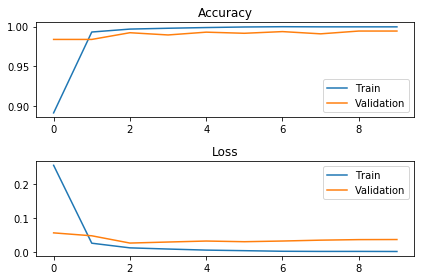

In [17]:
plt.subplot(211)
plt.title('Accuracy')
plt.plot(history.history['acc'], label='Train')
plt.plot(history.history['val_acc'], label='Validation')
plt.legend()

plt.subplot(212)
plt.title('Loss')
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend()

plt.tight_layout()

In [20]:
score, acc = mod.evaluate(X_test, y_test, batch_size=BATCH)
print('Test score: %.3f, accuracy: %.3f' % (score, acc))

for _ in range(5):
    idx = np.random.randint(len(X_test))
    x_test = X_test[idx].reshape(1, 40)
    y_label = y_test[idx]
    y_pred = mod.predict(x_test)[0][0]
    sent = ' '.join([index2word[x] for x in x_test[0].tolist() if x != 0])
    print('%.0f\t%d\t%s' % (y_pred, y_label, sent))

1418/1418 [==============================] - 0s 244us/step
Test score: 0.036, accuracy: 0.994
1	1	we saw mission impossible 3 , which was rather awesome .
0	0	i hate harry potter , it 's retarted , gay and stupid and there 's only one black guy ...
0	0	my dad 's being stupid about brokeback mountain ...
0	0	we went to see brokeback UNK was kinda horrible lol ...
0	0	i think i hate harry potter because it outshines much better reading material out there and the movies are just plain stupid to begin with .
